In [1]:
# Import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import cv2

#keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import sklearn.metrics as metrics
import ipyplot

In [3]:
train = pd.read_csv("archive/emnist-balanced-train.csv",delimiter = ',')
test = pd.read_csv("archive/emnist-balanced-test.csv", delimiter = ',')
mapp = pd.read_csv("archive/emnist-balanced-mapping.txt", delimiter = ' ', index_col=0, header=None, squeeze=True)
print("Train: %s, Test: %s, Map: %s" %(train.shape, test.shape, mapp.shape))

Train: (112799, 785), Test: (18799, 785), Map: (47,)


<ipython-input-3-614fb9dfc0b2>:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  mapp = pd.read_csv("archive/emnist-balanced-mapping.txt", delimiter = ' ', index_col=0, header=None, squeeze=True)


In [7]:
# Constants
HEIGHT = 28
WIDTH = 28

In [4]:
# Split x and y
train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]

test_x = test.iloc[:,1:]
test_y = test.iloc[:,0]
del test

In [5]:
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(112799, 784) (112799,) (18799, 784) (18799,)


In [5]:
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [8]:
# Flip and rotate image
train_x = np.asarray(train_x)
train_x = np.apply_along_axis(rotate, 1, train_x)
print ("train_x:",train_x.shape)

test_x = np.asarray(test_x)
test_x = np.apply_along_axis(rotate, 1, test_x)
print ("test_x:",test_x.shape)

train_x: (112799, 28, 28)
test_x: (18799, 28, 28)


In [9]:
# Normalise
train_x = train_x.astype('float32')
train_x /= 255
test_x = test_x.astype('float32')
test_x /= 255


In [12]:
lab = []
for i in range(112000, 112030):
    lab.append(chr(mapp[train_y[i]]))

In [13]:
ipyplot.plot_images(train_x[112000 : 112030], lab, max_images=21, img_width=150)

In [12]:
# number of classes
num_classes = train_y.nunique()

In [13]:
# One hot encoding
train_y = np_utils.to_categorical(train_y, num_classes)
test_y = np_utils.to_categorical(test_y, num_classes)
print("train_y: ", train_y.shape)
print("test_y: ", test_y.shape)

train_y:  (112799, 47)
test_y:  (18799, 47)


In [14]:
# Reshape image for CNN
train_x = train_x.reshape(-1, HEIGHT, WIDTH, 1)
test_x = test_x.reshape(-1, HEIGHT, WIDTH, 1)

In [15]:
# partition to train and val
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size= 0.10, random_state=7)

In [16]:
# Building model
# ((Si - Fi + 2P)/S) + 1
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(5,5), padding = 'same', activation='relu',\
                 input_shape=(HEIGHT, WIDTH,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3) , padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3) , padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
history = model.fit(train_x, train_y, epochs=1, batch_size=512, verbose=1, \
                    validation_data=(val_x, val_y))

199/199 [==============================] - 203s 1s/step - loss: 0.1599 - accuracy: 0.9328 - val_loss: 0.4659 - val_accuracy: 0.8851


In [ ]:
model.save('model.h5')


In [ ]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [ ]:
#%%
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

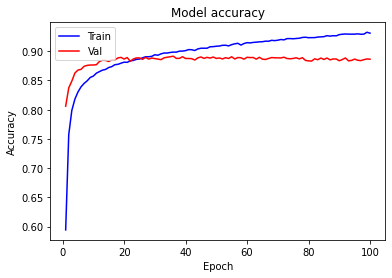

In [ ]:
# Accuracy curve
plotgraph(epochs, acc, val_acc)

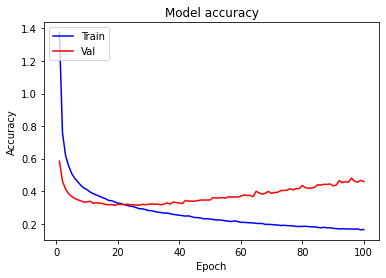

In [ ]:
# loss curve
plotgraph(epochs, loss, val_loss)

In [ ]:
score = model.evaluate(test_x, test_y, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.49255862832069397
Test accuracy: 0.8861109614372253


In [19]:
from tensorflow import keras
model = keras.models.load_model('model.h5')

In [20]:
y_pred = model.predict(test_x)
y_pred = (y_pred > 0.5)

588/588 [==============================] - 9s 16ms/step


In [21]:
test_y = np.array(test_y).argmax(axis=1)
y_pred = np.array(y_pred).argmax(axis=1)
test_y

array([39,  9, 26, ...,  1, 26, 33], dtype=int64)

In [ ]:
cm = metrics.confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))

In [22]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

Text(0.5, 0.98, 'Plot of confusion matrix')

<Figure size 720x360 with 0 Axes>

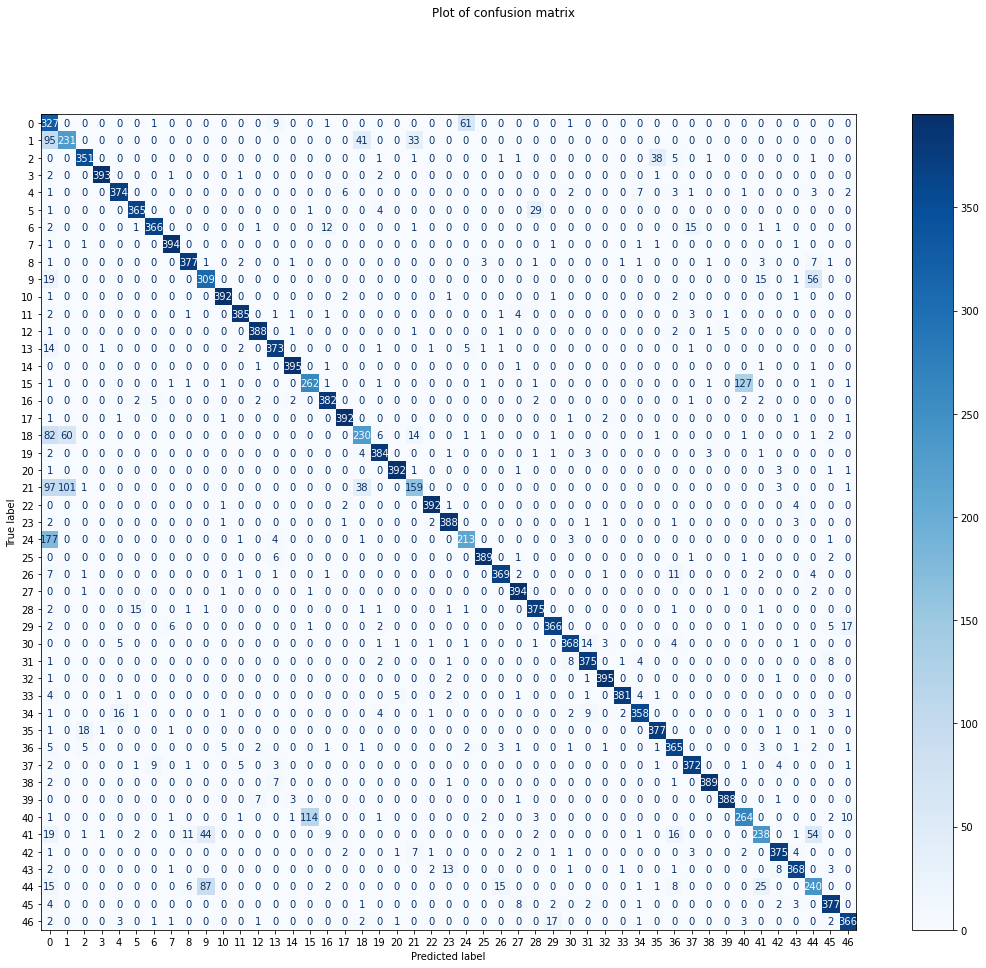

In [24]:
plt.figure(figsize=(10, 5))
disp = ConfusionMatrixDisplay.from_predictions(
                                              test_y, 
                                              y_pred, 
                                              cmap=plt.cm.Blues
                                              ) 
fig = disp.figure_
fig.set_figwidth(20)
fig.set_figheight(15) 
fig.suptitle('Plot of confusion matrix')